In [1]:
import os
import torch

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.amp import autocast, GradScaler

from torch.utils.data import random_split
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
from torchvision import models
from torchvision import transforms
from torchvision.models import ResNet152_Weights

from torchmetrics.classification import MulticlassF1Score

In [2]:
def resize(img, target_size=256):
    w, h = img.size
    ratio = target_size / h if w > h else target_size / w
    return img.resize((int(w*ratio), int(h*ratio)))

hyperparams = {
    "train_val_ratio" : 0.8,
    "batch_size" : 80,
    "learning_rate" : 0.0001,
    "epochs" : 3,
    "transform" : transforms.Compose(
        [
            transforms.Lambda(resize),
            # transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]
    )
}

dataset = ImageFolder("./data/train", transform=hyperparams["transform"])

# Train, Val 데이터 분리
train_size = int(len(dataset) * hyperparams["train_val_ratio"])
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Train, Val 데이터 로더 정의
train_dataloader = DataLoader(
    train_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True
)

# 모델 정의
model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(dataset.classes))

# 모델 불러오기
model_path = "./models/resnet152.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("model param load")

model param load


## 모델 학습

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])
scaler = GradScaler() 

for epoch in range(hyperparams["epochs"]):
    cost = 0.0
    model.train()

    for img, cls in train_dataloader:
        img = img.to(device)
        cls = cls.to(device)

        optimizer.zero_grad()

        with autocast(device_type="cuda"): 
            output = model(img)
            loss = criterion(output, cls)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        cost += loss.item()

    cost = cost / len(train_dataloader)

    # 모델 검증
    model.eval()
    acc = 0
    total = 0

    # F1 metric 초기화
    f1_metric = MulticlassF1Score(num_classes=7, average='macro').to(device)
    f1_metric.reset()

    with torch.no_grad():
        for img, cls in val_dataloader:
            img = img.to(device)
            cls = cls.to(device)

            with autocast(device_type="cuda"):
                outputs = model(img)
                preds = torch.argmax(outputs, dim=1)

            acc += (preds == cls).sum().item()
            total += cls.size(0)

            f1_metric.update(preds, cls)

    acc_score = acc / total * 100
    f1_score_macro = f1_metric.compute().item()

    print(f"Epoch: {epoch+1:3d}, Cost: {cost:.4f}, acc@1: {acc_score:.2f}%, F1-macro: {f1_score_macro:.4f}")

    # 모델 저장
    if os.path.exists(model_path):
        os.remove(model_path)
    torch.save(model.state_dict(), model_path)

cuda


## 모델 추론

In [21]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import pandas as pd

# 모델 로드
model = models.resnet152()
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model.load_state_dict(torch.load(model_path, map_location="cuda"))
model.eval().cuda()

# 전처리 정의
transform = transforms.Compose([
    transforms.Lambda(resize),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 테스트 이미지 로드
test_dir = "./data/test"
image_files = sorted([f for f in os.listdir(test_dir) if f.endswith(".jpg")])

# 배치 추론 설정
batch_size = 64
results = []
batch_images = []
batch_names = []

for i, fname in enumerate(image_files):
    path = os.path.join(test_dir, fname)
    img = Image.open(path).convert("RGB")
    img_tensor = transform(img)
    batch_images.append(img_tensor)
    batch_names.append(fname)

    # 배치 단위로 추론하거나 마지막 남은 이미지들 처리
    if len(batch_images) == batch_size or i == len(image_files) - 1:
        input_tensor = torch.stack(batch_images).cuda()
        with torch.no_grad():
            outputs = model(input_tensor)
            preds = torch.argmax(outputs, dim=1).tolist()

        for name, pred in zip(batch_names, preds):
            image_id = os.path.splitext(name)[0]
            pred_label = dataset.classes[pred]
            results.append((image_id, pred_label))

        # 배치 초기화
        batch_images.clear()
        batch_names.clear()

# 결과 저장
df = pd.DataFrame(results, columns=["ID", "rock_type"])
sub_path = "./data/rock_submission.csv"
if os.path.exists(sub_path):
    os.remove(sub_path)
df.to_csv(sub_path, index=False)


## CAM 확인

Model parameters loaded


100%|██████████| 64/64 [00:05<00:00, 12.57it/s]


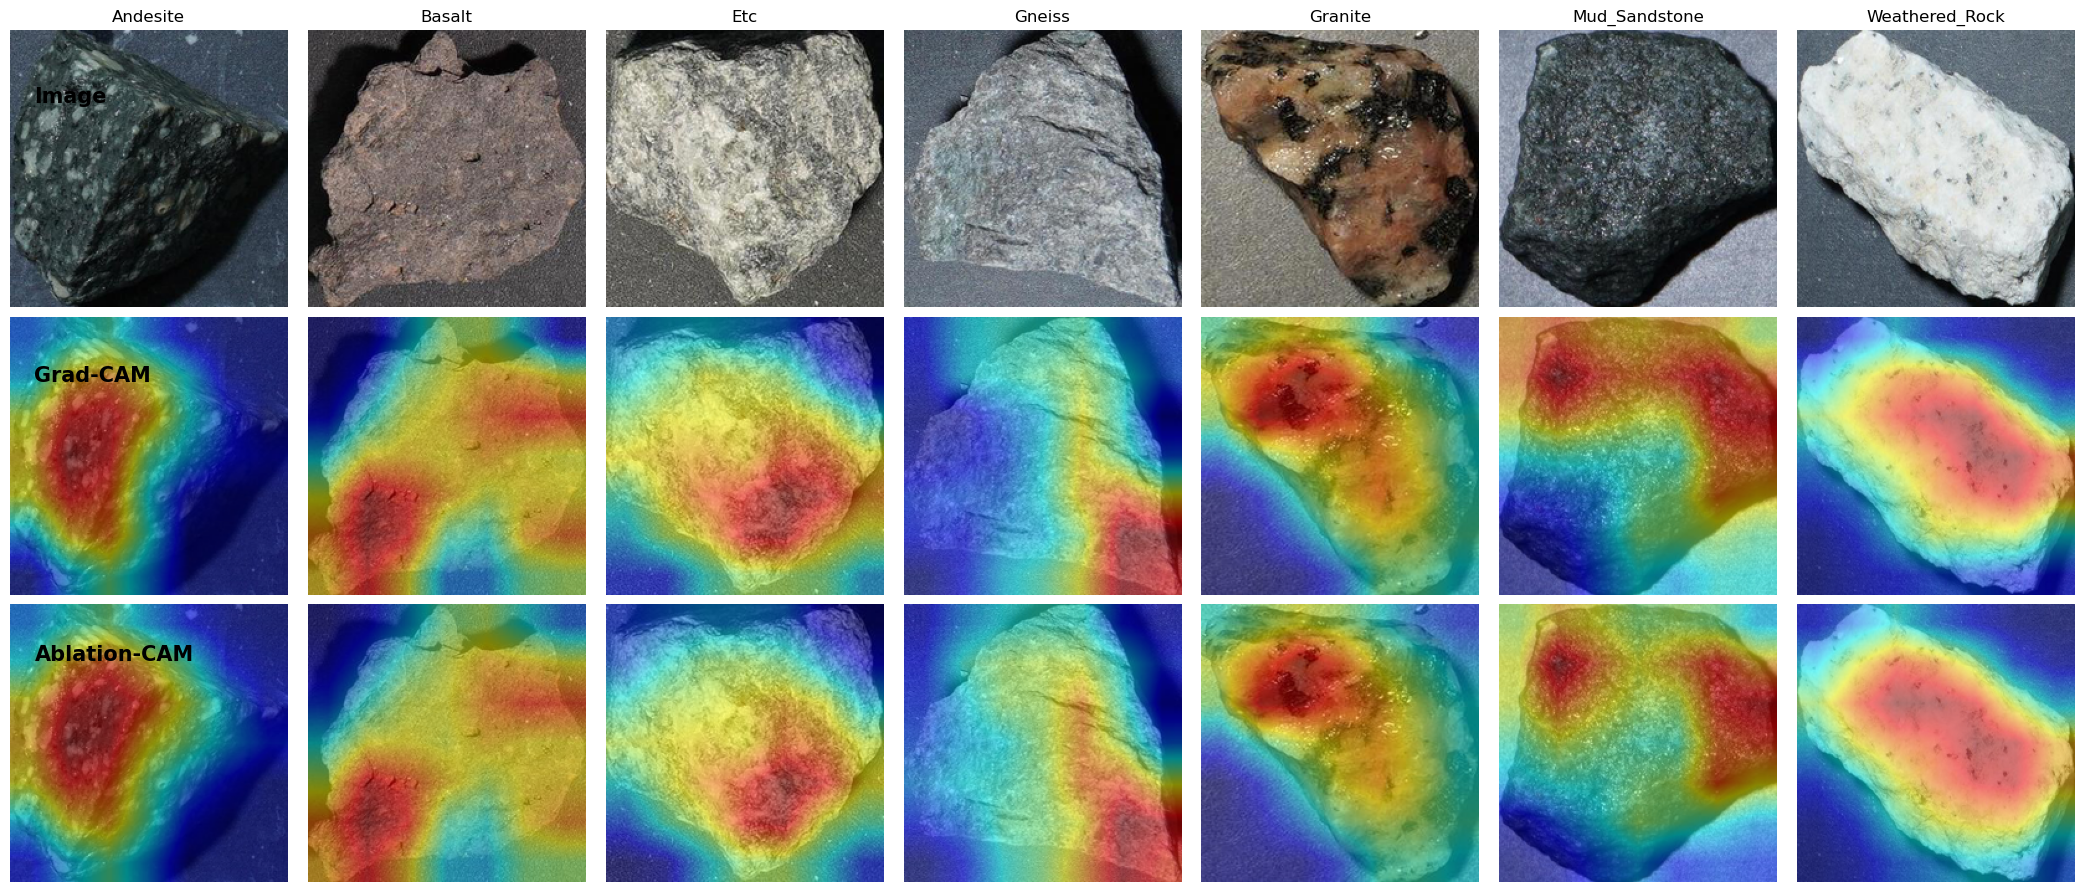

In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import torch
from torch import nn
from torchvision import models, transforms

from pytorch_grad_cam import GradCAM, AblationCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

device = "cuda" if torch.cuda.is_available() else "cpu"

# 모델 준비
model = models.resnet152(weights=None)
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device).eval()

model_path = "./models/resnet152.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model parameters loaded")

# 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 클래스별로 이미지 하나씩 뽑기
data_dir = "./data/train"
class_names = sorted(os.listdir(data_dir))
num_classes = len(class_names)

original_images = []
grad_images = []
ablation_images = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    if not image_files:
        continue
    image_path = os.path.join(class_dir, random.choice(image_files))

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # 모델 추론
    with torch.no_grad():
        output = model(input_tensor)
    top_class = output.argmax(dim=1).item()
    targets = [ClassifierOutputTarget(top_class)]

    # 원본 이미지 numpy로
    rgb_image = np.array(image.resize((224, 224))).astype(np.float32) / 255.0

    # Grad-CAM
    cam_grad = GradCAM(model=model, target_layers=[model.layer4[-1]])
    grayscale_cam_grad = cam_grad(input_tensor=input_tensor, targets=targets)[0]
    visual_grad = show_cam_on_image(rgb_image, grayscale_cam_grad, use_rgb=True)

    # Ablation-CAM
    cam_ablation = AblationCAM(model=model, target_layers=[model.layer4[-1]])
    grayscale_cam_ablation = cam_ablation(input_tensor=input_tensor, targets=targets)[0]
    visual_ablation = show_cam_on_image(rgb_image, grayscale_cam_ablation, use_rgb=True)

    # 저장
    original_images.append(rgb_image)
    grad_images.append(visual_grad)
    ablation_images.append(visual_ablation)

# 시각화
row_titles = ["Image", "Grad-CAM", "Ablation-CAM"]

fig, axes = plt.subplots(3, num_classes, figsize=(3*num_classes, 9))

for row_idx, image_list in enumerate([original_images, grad_images, ablation_images]):
    for col_idx in range(num_classes):
        ax = axes[row_idx, col_idx]
        ax.imshow(image_list[col_idx])
        ax.axis('off')
        if row_idx == 0:
            ax.set_title(class_names[col_idx], fontsize=12)

# 세로축 표시
for row_idx, label in enumerate(row_titles):
    fig.text(0.02,
             0.89 - row_idx * 0.31,
             label,
             va='center',
             ha='left',
             fontsize=15,
             weight='bold')

plt.tight_layout()
plt.show()
